# 三、建模调参

## 1. 读取数据


In [98]:
import numpy as np
import pandas as pd
import warnings

x_train = pd.read_csv('./data/processed_train.csv')
y_train = pd.read_csv('./data/label.csv', squeeze=True)
x_test = pd.read_csv('./data/processed_test.csv')

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(788904, 149)
(788904,)
(200000, 149)


In [38]:
print(x_train.head())
print(y_train.head())
print(x_test.head())

term  interestRate  ...  loanAmnt_to_mean_postCode  annualIncome_to_mean_postCode
0     5         19.52  ...                   2.385060                       1.537417
1     5         18.49  ...                   1.136684                       0.528130
2     5         16.99  ...                   0.857246                       1.073959
3     3          7.26  ...                   0.814197                       1.807126
4     3         12.99  ...                   0.224805                       0.466473

[5 rows x 149 columns]
0    1
1    0
2    0
3    0
4    0
Name: isDefault, dtype: int64
   term  interestRate  ...  loanAmnt_to_mean_postCode  annualIncome_to_mean_postCode
0     3         10.99  ...                   1.003175                       1.023160
1     5         14.65  ...                   1.417239                       0.652790
2     3         19.99  ...                   0.882293                       0.806080
3     5         14.31  ...                   1.148687           

In [99]:
# 减小数据占用的内存空间
def reduse_mem_usage(df):
    start_mem = df.memory_usage().sum()
    print('原始数据使用内存：{:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()
    print("优化后数据使用内存：{:.2f} MB".format(end_mem))
    return df

In [100]:
# 优化数据内存结构
x_train = reduse_mem_usage(x_train)
x_test = reduse_mem_usage(x_test)

原始数据使用内存：940373648.00 MB
优化后数据使用内存：222471008.00 MB
原始数据使用内存：238400080.00 MB
优化后数据使用内存：50400080.00 MB


## 2. 简单建模

In [101]:
from sklearn.model_selection import KFold, train_test_split
import lightgbm as lgb

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

# 数据分割
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train.iloc[:10000, :], y_train[:10000], test_size=0.2)
train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(x_val_split, label=y_val_split)

# 模型参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1,
    'metric': 'auc',
    'min_child_weight': 1e-3,
    'num_leaves': 31,
    'max_depth': -1,
    'reg_lambda': 0,
    'reg_alpha': 0,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 0,
    'seed': 2020,
    'nthread': 8,
    'silent': True,
    'verbose': -1,
}

# 训练模型
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.721573


没有调参前lightgbm在验证集上的AUC:  0.7332612696932298


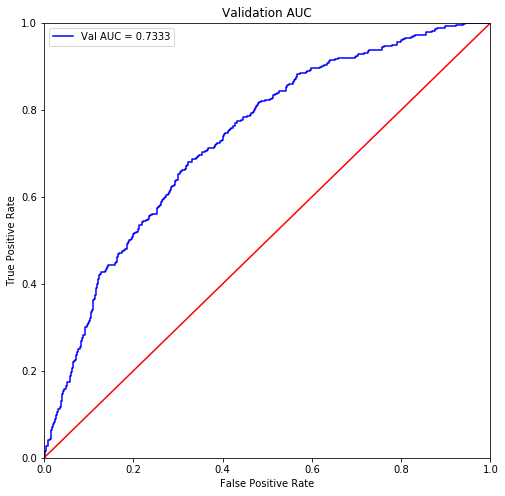

In [50]:
# 对验证集进行预测
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

val_pre_lgb = model.predict(x_val_split, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val_split, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print("没有调参前lightgbm在验证集上的AUC: ", roc_auc)

# 画出auc曲线
plt.figure(figsize=(8, 8))
plt.title("Validation AUC")
plt.plot(fpr, tpr, color='b', label='Val AUC = %0.4f' %roc_auc)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# 画出对角线
plt.plot([0, 1], [0 ,1], color='r', linestyle='-')
plt.show()

In [102]:
# 然后使用5折交叉验证
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(x_train.iloc[:10000, :], y_train[:10000])):
    print("*"*10 + str(i+1) + "*"*10)
    x_train_split, y_train_split, x_valid_split, y_valid_split = x_train.iloc[train_index], y_train.iloc[train_index], x_train.iloc[valid_index], y_train.iloc[valid_index]
    # 创建lightgbm需要的数据集
    train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(x_valid_split, label=y_valid_split)
    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    # 模型训练
    model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)
    # 验证集预测
    val_pred = model.predict(x_valid_split, num_iteration=model.best_iteration)
    # 计算auc
    auc = roc_auc_score(y_valid_split, val_pred)
    cv_scores.append(auc)
    print(cv_scores)

print("lightgbm score list: ", cv_scores)
print("lightgbm score mean: ", np.mean(cv_scores))
print("lightgbm score std: ", np.std(cv_scores))

**********1**********
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.722751
[0.7227511736662471]
**********2**********
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.703653
[0.7227511736662471, 0.7036528266197783]
**********3**********
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[159]	valid_0's auc: 0.680637
[0.7227511736662471, 0.7036528266197783, 0.6806372366559964]
**********4**********
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.71493
[0.7227511736662471, 0.7036528266197783, 0.6806372366559964, 0.7149302040190213]
**********5**********
[LightGBM] [Warning] Unknown parameter: s

## 3. 模型调参

In [103]:
# 首先尝试一下网格调参
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def getBestCVParams(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 5k交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    model_lgb = lgb.LGBMClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        num_leaves=num_leaves,
        max_depth=max_depth,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        bagging_freq=bagging_freq,
        min_data_in_leaf=min_data_in_leaf,
        min_child_weight=min_child_weight,
        min_split_gain=min_split_gain,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        n_jobs= 8
    )

    grid_search = GridSearchCV(estimator=model_lgb, cv=cv_fold, param_grid=param_grid, scoring='roc_auc')
    grid_search.fit(x_train.iloc[:50000, :], y_train[:50000])

    print("模型当前最优参数：{}".format(grid_search.best_params_))
    print("模型当前最优得分：{}".format(grid_search.best_score_))

In [78]:
# num_leaves
lgb_params = {'num_leaves': range(28, 35, 1)}
getBestCVParams(learning_rate=0.1, n_estimators=200, num_leaves=None, max_depth=None, min_data_in_leaf=None, 
                   min_child_weight=0.001, bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [79]:
# num_leaves
lgb_params = {'max_depth': range(5, 15, 1)}
getBestCVParams(learning_rate=0.1, n_estimators=200, num_leaves=30, max_depth=None, min_data_in_leaf=None, 
                   min_child_weight=0.001, bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 

In [80]:
# bagging_fraction, feature_fraction, bagging_freq
lgb_params = {'bagging_fraction': [i/10 for i in range(1,10,2)], 
              'feature_fraction': [i/10 for i in range(1,10,2)],
              'bagging_freq': range(0,21,10)
             }
getBestCVParams(learning_rate=0.1, n_estimators=200, num_leaves=30, max_depth=5, min_data_in_leaf=45, 
                   min_child_weight=0.001, bagging_fraction=None, feature_fraction=None, bagging_freq=None, 
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)

rrent value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feat

In [81]:
lgb_params = {'reg_lambda': [0,0.001,0.01,0.3,0.5], 'reg_alpha': [0,0.001,0.01,0.3,0.5]}
getBestCVParams(learning_rate=0.1, n_estimators=200, num_leaves=30, max_depth=5, min_data_in_leaf=45, 
                   min_child_weight=0.001, bagging_fraction=0.1, feature_fraction=0.1, bagging_freq=0, 
                   min_split_gain=0, reg_lambda=None, reg_alpha=None, param_grid=lgb_params)

rrent value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] bag

In [83]:
final_params = {
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 30,
                'max_depth': 5,
                'min_data_in_leaf': 45,
                'min_child_weight': 0.001,
                'bagging_fraction': 0.1,
                'feature_fraction': 0.1,
                'bagging_freq': 0,
                'min_split_gain': 0,
                'reg_lambda': 0.01,
                'reg_alpha':0.5,
                'nthread': 6
               }

cv_result = lgb.cv(train_set=train_matrix,
                   early_stopping_rounds=20,
                   num_boost_round=5000,
                   nfold=5,
                   stratified=True,
                   shuffle=True,
                   params=final_params,
                   metrics='auc',
                   seed=0,
                  )

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8320
[LightGBM] [Info] Number of data points in the train set: 6399, number of used features: 132
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8320
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 132
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8320
[LightGBM] [Info] Number of data points in the train set: 6400, number of us

In [84]:
print('迭代次数{}'.format(len(cv_result['auc-mean'])))
print('交叉验证的AUC为{}'.format(max(cv_result['auc-mean'])))

迭代次数452
交叉验证的AUC为0.7078868331434022


In [104]:
## 然后尝试一下 贝叶斯调参
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, x_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val

In [87]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_fraction is set=0.94, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94
[LightGBM] [Warning] bagging_freq is set=63, subsample_freq=0 will be ignored. Current value: bagging_freq=63
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.57, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.57
[LightGBM] [Warning] min_data_in_leaf is set=97, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=97
[LightGBM] [Warning] bagging_fraction is set=0.94, subsample=1.0 will be ignored. Current value: bagging_fraction=0.94
[LightGBM] [Warning] bagging_freq is set=63, subsample_freq=0 will be ignored. Current value: bagging_freq=63
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.57, colsample_bytree=1.0 will be ignored. Current value: feature_fractio

In [88]:
print(bayes_lgb.max)

{'target': 0.7065815518360757, 'params': {'bagging_fraction': 0.8496984134074861, 'bagging_freq': 92.96987166784653, 'feature_fraction': 0.8598321380510618, 'max_depth': 3.120613351718626, 'min_child_weight': 2.0678840945413715, 'min_data_in_leaf': 13.177271550798757, 'min_split_gain': 0.35574304474312846, 'num_leaves': 14.06572032222628, 'reg_alpha': 7.882068158059569, 'reg_lambda': 7.281811950770366}}


In [93]:
# 然后使用5折交叉验证
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(x_train.iloc[:10000, :], y_train[:10000])):
    print("*"*10 + str(i+1) + "*"*10)
    x_train_split, y_train_split, x_valid_split, y_valid_split = x_train.iloc[train_index], y_train.iloc[train_index], x_train.iloc[valid_index], y_train.iloc[valid_index]
    # 创建lightgbm需要的数据集
    train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(x_valid_split, label=y_valid_split)
    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.01,
                'metric': 'auc',
                'min_child_weight': 2.06,
                'num_leaves': 14,
                'max_depth': 3,
                'reg_lambda': 7.28,
                'reg_alpha': 7.88,
                'feature_fraction': 0.86,
                'bagging_fraction': 0.85,
                'bagging_freq': 93,
                'min_data_in_leaf': 13,
                'seed': 2020,
                'nthread': 8,
                'silent': True
    }
    # 模型训练
    model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)
    # 验证集预测
    val_pred = model.predict(x_valid_split, num_iteration=model.best_iteration)
    # 计算auc
    auc = roc_auc_score(y_valid_split, val_pred)
    cv_scores.append(auc)
    print(cv_scores)

print("lightgbm score list: ", cv_scores)
print("lightgbm score mean: ", np.mean(cv_scores))
print("lightgbm score std: ", np.std(cv_scores))

 gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

ain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

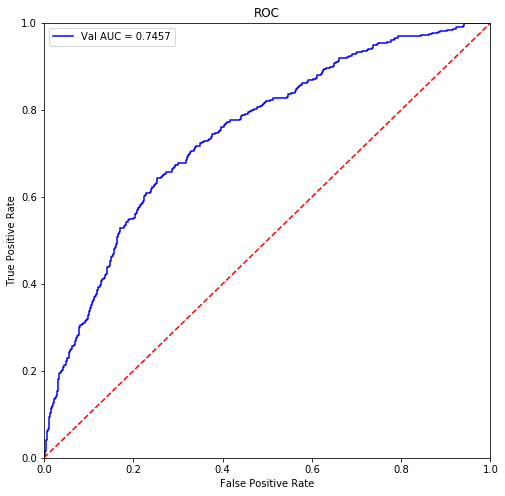

In [107]:
# 加大数据集
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train.iloc[:800000, :], y_train[:800000], test_size=0.2)
train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(x_val_split, label=y_val_split)

base_params_lgb = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.01,
                'metric': 'auc',
                'min_child_weight': 2.06,
                'num_leaves': 14,
                'max_depth': 3,
                'reg_lambda': 7.28,
                'reg_alpha': 7.88,
                'feature_fraction': 0.86,
                'bagging_fraction': 0.85,
                'bagging_freq': 93,
                'min_data_in_leaf': 13,
                'seed': 2020,
                'nthread': 8,
                'silent': True
    }

final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(x_valid_split)
fpr, tpr, threshold = metrics.roc_curve(y_valid_split, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [108]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(final_model_lgb, open('data/model_lgb_best.pkl', 'wb'))